In [2]:
# install java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment.
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"


# install findspark using pip
!pip install -q findspark

In [3]:
# Start a Spark session
import findspark
findspark.init()
from pyspark.sql import SparkSession
#spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.master("local[*]").enableHiveSupport().getOrCreate()

In [4]:
spark = SparkSession.builder \
    .appName("BostonHousing") \
    .config("spark.sql.warehouse.dir", "/user/hive/warehouse") \
    .config("hive.metastore.uris", "thrift://localhost:9083") \
    .enableHiveSupport() \
    .getOrCreate()

In [5]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving BostonHousing.csv to BostonHousing.csv


In [6]:
# Read the dataset into a Spark DataFrame
file_path = "BostonHousing.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [7]:
# Create a Hive table from the DataFrame
df.createOrReplaceTempView("boston_housing")

In [8]:
### Task 1. Data Overview
# 1.1 Retrieve and display the first 5 rows
spark.sql("SELECT * FROM boston_housing LIMIT 5").show()

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+



In [9]:
# 1.2 Find the total number of records
spark.sql("SELECT COUNT(*) AS total_records FROM boston_housing").show()

+-------------+
|total_records|
+-------------+
|          506|
+-------------+



In [10]:
### Task 2: Descriptive Statistics
# 2.1 Basic statistics for "medv"
spark.sql("""
SELECT
    AVG(medv) AS mean_medv,
    STDDEV(medv) AS stddev_medv,
    MIN(medv) AS min_medv,
    MAX(medv) AS max_medv
FROM boston_housing
""").show()


+------------------+-----------------+--------+--------+
|         mean_medv|      stddev_medv|min_medv|max_medv|
+------------------+-----------------+--------+--------+
|22.532806324110698|9.197104087379815|     5.0|    50.0|
+------------------+-----------------+--------+--------+



In [11]:
# 2.2 Calculate mean of "rm"
spark.sql("SELECT AVG(rm) AS mean_rm FROM boston_housing").show()

+-----------------+
|          mean_rm|
+-----------------+
|6.284634387351787|
+-----------------+



In [12]:
### Task 3: Data Exploration
# 3.1 Property with the highest crime rate
spark.sql("SELECT * FROM boston_housing ORDER BY crim DESC LIMIT 1").show()


+-------+---+-----+----+-----+-----+----+------+---+---+-------+-----+-----+----+
|   crim| zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|    b|lstat|medv|
+-------+---+-----+----+-----+-----+----+------+---+---+-------+-----+-----+----+
|88.9762|0.0| 18.1|   0|0.671|6.968|91.9|1.4165| 24|666|   20.2|396.9|17.21|10.4|
+-------+---+-----+----+-----+-----+----+------+---+---+-------+-----+-----+----+



In [13]:
# 3.2 Property with the lowest median home value
spark.sql("SELECT * FROM boston_housing ORDER BY medv ASC LIMIT 1").show()

+-------+---+-----+----+-----+-----+-----+------+---+---+-------+-----+-----+----+
|   crim| zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|    b|lstat|medv|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+-----+-----+----+
|38.3518|0.0| 18.1|   0|0.693|5.453|100.0|1.4896| 24|666|   20.2|396.9|30.59| 5.0|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+-----+-----+----+



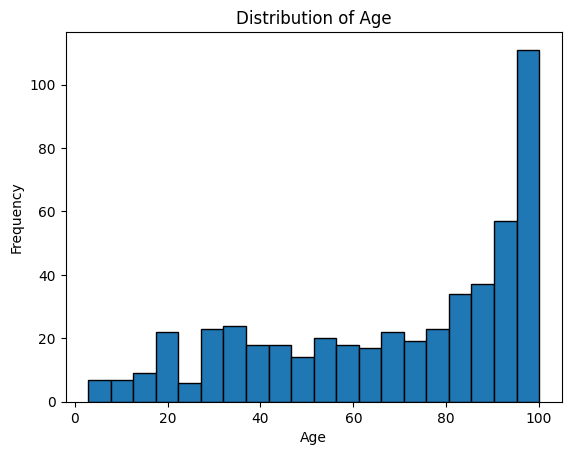

In [14]:
### Task 4: Data Distribution Analysis
# 4.1 histogram showing the distribution of the "age" column

import pandas as pd
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pdf = df.select("age").toPandas()

plt.hist(pdf['age'], bins=20, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')
plt.show()

In [15]:
# 4.2 Percentage of properties with "chas" value of 1
spark.sql("""
SELECT
    (COUNT(*) * 100.0 / (SELECT COUNT(*) FROM boston_housing)) AS percent_chas_1
FROM boston_housing
WHERE chas = 1
""").show()

+----------------+
|  percent_chas_1|
+----------------+
|6.91699604743083|
+----------------+



In [16]:
### Task 5: Correlation Analysis

# 5.1 Correlation coefficient between "rm" and "medv"
spark.sql("SELECT CORR(rm, medv) AS corr_rm_medv FROM boston_housing").show()

+------------------+
|      corr_rm_medv|
+------------------+
|0.6953599470715401|
+------------------+



In [17]:
# 5.2 Correlation between "ptratio" and "nox"
spark.sql("SELECT CORR(ptratio, nox) AS corr_ptratio_nox FROM boston_housing").show()

+-------------------+
|   corr_ptratio_nox|
+-------------------+
|0.18893267711276893|
+-------------------+



In [21]:
### Task 6: Advanced Querying

# 6.1 Top 5 neighborhoods with highest median home values
from pyspark.sql.window import Window

windowSpec  = Window.orderBy("medv") # Now Window is defined
spark.sql("""
SELECT b, medv, rank() OVER (ORDER BY medv ASC) as rank_num
FROM boston_housing
""") \
.filter("rank_num <= 5") \
.select("b", "medv")\
.orderBy("b", ascending=False).show()

+------+----+
|     b|medv|
+------+----+
| 396.9| 5.6|
| 396.9| 5.0|
|384.97| 5.0|
|344.05| 7.0|
|338.16| 6.3|
| 88.27| 7.0|
+------+----+



In [ ]:
# 6.2 Average property age for neighborhoods with "chas" value of 1 vs 0
spark.sql("SELECT chas, AVG(age) AS avg_age FROM boston_housing GROUP BY chas").show()

+----+-----------------+
|chas|          avg_age|
+----+-----------------+
|   1|77.50000000000001|
|   0|67.91167728237794|
+----+-----------------+



In [24]:
### Task 7: Visualization

# 7.1 Create a Hive view named "property_age_view"
spark.sql("CREATE OR REPLACE TEMP VIEW property_age_view AS SELECT age, medv FROM boston_housing")

DataFrame[]

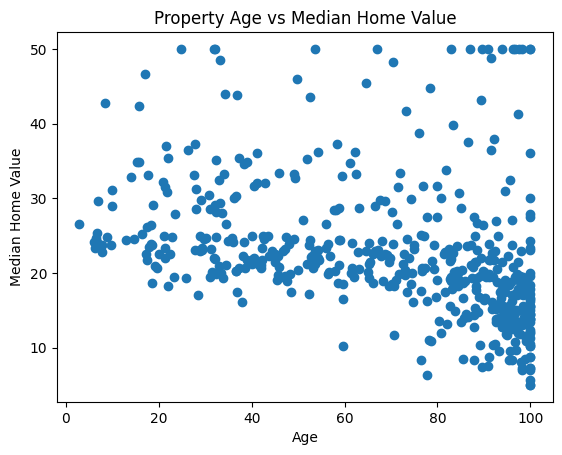

In [ ]:
# 7.2 Plot a scatter plot of property age against median home value
# Convert the view to Pandas DataFrame
pdf = spark.sql("SELECT * FROM property_age_view").toPandas()

plt.scatter(pdf['age'], pdf['medv'])
plt.xlabel('Age')
plt.ylabel('Median Home Value')
plt.title('Property Age vs Median Home Value')
plt.show()

In [ ]:
### Task 8: Outliers Detection

# 8.1 Properties with "crim" value greater than 10
spark.sql("SELECT * FROM boston_housing WHERE crim > 10").show()

+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|   crim| zn|indus|chas|  nox|   rm|  age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+---+-----+----+-----+-----+-----+------+---+---+-------+------+-----+----+
|13.5222|0.0| 18.1|   0|0.631|3.863|100.0|1.5106| 24|666|   20.2|131.42|13.33|23.1|
|11.1081|0.0| 18.1|   0|0.668|4.906|100.0|1.1742| 24|666|   20.2| 396.9|34.77|13.8|
|18.4982|0.0| 18.1|   0|0.668|4.138|100.0| 1.137| 24|666|   20.2| 396.9|37.97|13.8|
|19.6091|0.0| 18.1|   0|0.671|7.313| 97.9|1.3163| 24|666|   20.2| 396.9|13.44|15.0|
| 15.288|0.0| 18.1|   0|0.671|6.649| 93.3|1.3449| 24|666|   20.2|363.02|23.24|13.9|
|23.6482|0.0| 18.1|   0|0.671| 6.38| 96.2|1.3861| 24|666|   20.2| 396.9|23.69|13.1|
|17.8667|0.0| 18.1|   0|0.671|6.223|100.0|1.3861| 24|666|   20.2|393.74|21.78|10.2|
|88.9762|0.0| 18.1|   0|0.671|6.968| 91.9|1.4165| 24|666|   20.2| 396.9|17.21|10.4|
|15.8744|0.0| 18.1|   0|0.671|6.545| 99.1|1.5192| 24|666|   20.2| 396.9|21.0

# 8.2 Discuss the significance of outliers
(reference: https://www.psychologytoday.com/us/blog/singular-perspective/202102/the-importance-outliers)

1.  Clues for Unforeseen Patterns: Outliers can signal underlying new
     patterns or trends that are not immediately apparent.
2.  Potential for Discovery: Outliers can lead to significant discoveries
     and breakthroughs. They can reveal important information that can change established practices and lead to innovations.
3.  Identifying Errors and Anomalies: Outliers can result from human
     error, sampling errors, or misreporting. Identifying and analyzing these outliers can help in improving data collection and processing methods.
4.  Opportunities for Further Research: The presence of outliers can
     highlight areas that require further investigation.
5.  Uncovering Rare Phenomena: Outliers help in identifying and studying  
     rare phenomena that might otherwise be overlooked





## **Task 9: Hypothesis Testing**

## 9.1 Formulate a hypothesis
*   **Null Hypothesis (H0)**: The average number of rooms does not have a
     significant impact on the median home value.
*   **Alternative Hypothesis (H1**): The average number of rooms has a
     significant impact on the median home value.


In [27]:
# 9.2 Conduct a t-test using HiveQL

# Calculate summary statistics for rm and medv
summary_stats = spark.sql("""
    SELECT
        AVG(rm) AS mean_rm,
        VARIANCE(rm) AS var_rm,
        AVG(medv) AS mean_medv,
        VARIANCE(medv) AS var_medv,
        COUNT(*) AS n
    FROM boston_housing
""")
summary_stats.show()


+-----------------+-------------------+------------------+----------------+---+
|          mean_rm|             var_rm|         mean_medv|        var_medv|  n|
+-----------------+-------------------+------------------+----------------+---+
|6.284634387351787|0.49367085022110885|22.532806324110698|84.5867235940985|506|
+-----------------+-------------------+------------------+----------------+---+



In [28]:
# Calculate the t-statistic using the summary statistics
summary_stats.createOrReplaceTempView("summary_stats")

t_stat_calc = spark.sql("""
    SELECT
        mean_rm,
        mean_medv,
        var_rm,
        var_medv,
        n,
        (mean_rm - mean_medv) / SQRT((var_rm / n) + (var_medv / n)) AS t_stat
    FROM summary_stats
""")
t_stat_calc.show()


+-----------------+------------------+-------------------+----------------+---+------------------+
|          mean_rm|         mean_medv|             var_rm|        var_medv|  n|            t_stat|
+-----------------+------------------+-------------------+----------------+---+------------------+
|6.284634387351787|22.532806324110698|0.49367085022110885|84.5867235940985|506|-39.62461149680037|
+-----------------+------------------+-------------------+----------------+---+------------------+



In [29]:
# Export Results from PySpark SQL to Pandas and Calculate P-Value

summary_stats_df = summary_stats.toPandas()
t_stat_calc_df = t_stat_calc.toPandas()

mean_rm = summary_stats_df.at[0, 'mean_rm']
mean_medv = summary_stats_df.at[0, 'mean_medv']
var_rm = summary_stats_df.at[0, 'var_rm']
var_medv = summary_stats_df.at[0, 'var_medv']
n = summary_stats_df.at[0, 'n']
t_stat = t_stat_calc_df.at[0, 't_stat']

# Degrees of freedom
df = n - 2

# Calculate the p-value
import scipy.stats as stats
p_value = stats.t.sf(abs(t_stat), df) * 2

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Determine the significance level
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant impact of the average number of rooms on the median home value.")
else:
    print("Fail to reject the null hypothesis. There is no significant impact of the average number of rooms on the median home value.")


T-Statistic: -39.62461149680037, P-Value: 6.047544328582182e-157
Reject the null hypothesis. There is a significant impact of the average number of rooms on the median home value.
